### Phase contrast imaging of gold nanoparticles on amorphous carbon

In this tutorial notebook, we will reconstruct a phase contrast image from gold nanoparticles on a carbon support. We will use differential phase contrast (DPC), parallax depth sectioning (also known as S-matrix reconstruction, or tilt-corrected bright field imaging) and ptychography. In this dataset, the probe is defocused which provides a good imaging condition for both parallax depth sectioning and ptychography, but poorer image quality for virtual dark field and bright field imaging, and DPC.

### Downloads

* [4D-STEM dataset](https://drive.google.com/file/d/1KYxE-RbPIXm7A_BCb0V85NnuOWGufHE1/view?usp=share_link)
* [vacuum probe intensity](https://drive.google.com/file/d/15AuJoEDeb8HXnUyhJqq7jNEfErKgPr7p/view?usp=share_link)

### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Georgios Varnavides (gvarnavides@berkeley.edu)
- Stephanie Ribet (sribet@lbl.gov)
- Colin Ophus (clophus@lbl.gov)

The 4D-STEM dataset used here was recorded by Stephanie Ribet on the TEAM I microscope, at the National Center for Electron Microscopy, a part of the Molecular Foundry DOE User Facility.

Updated 2023 Nov 4

In [1]:
import numpy as np
import py4DSTEM
print(py4DSTEM.__version__)

0.14.8


In [4]:
file_path = 'data/'
file_data = file_path + 'ptycho_gold_data.h5'
file_probe = file_path + 'ptycho_gold_probe.h5'

# Load data, basic visualization

In [5]:
dataset = py4DSTEM.read(file_data)
probe = py4DSTEM.read(file_probe)

We calculate and plot mean diffraction pattern and vacuum probe measurement:

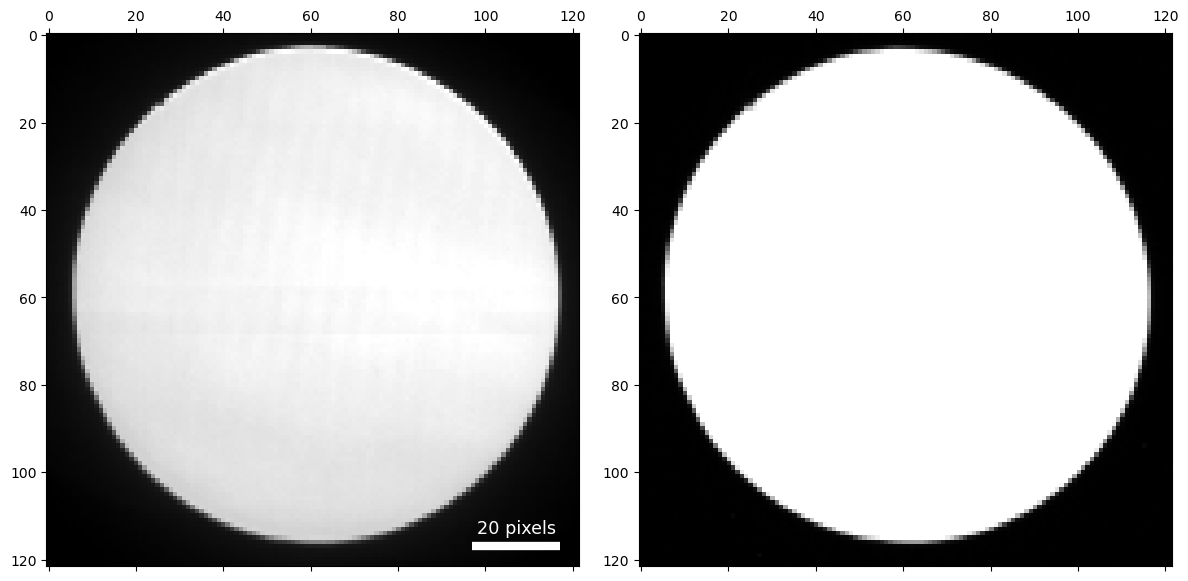

In [6]:
dataset.get_dp_mean();

py4DSTEM.show(
    [
        dataset.tree('dp_mean'),
        probe.data
    ]
)

# Calibration

We estimate the probe radius:

In [7]:
probe_radius_pixels, probe_qx0, probe_qy0 = dataset.get_probe_size(probe.data)

This allows us to manually set the calibrations from known values:
- probe step size of 2 Angstroms
- probe convergence semiangle of 17.1 mrads

In [8]:
dataset.calibration.set_R_pixel_size(2)
dataset.calibration.set_R_pixel_units('A')
dataset.calibration.set_Q_pixel_size(17.1 / probe_radius_pixels)
dataset.calibration.set_Q_pixel_units('mrad')
dataset.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:      0.3060331070805141
             R_pixel_size:      2
             Q_pixel_units:     mrad
             R_pixel_units:     A
             probe_semiangle:   55.87630751172673
             qx0_mean:          59.77351970240072
             qy0_mean:          60.739062005587186
)

# Virtual images

Next, we create BF and DF virtual images by using the detected radius

100%|██████████████████████████████████████████████████████████████| 4096/4096 [00:00<00:00, 45426.92it/s]


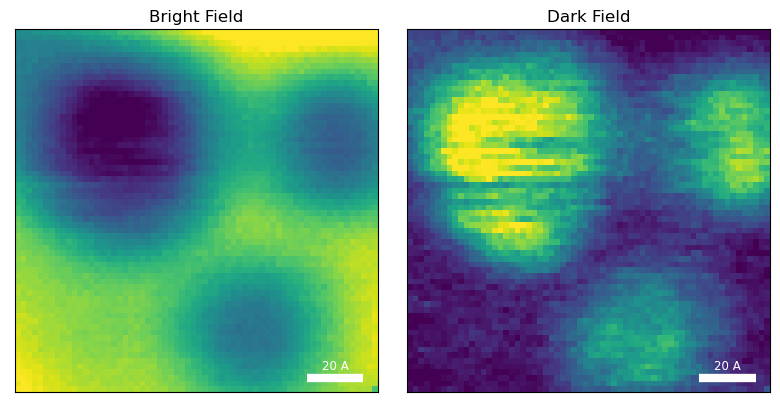

In [9]:
expand_BF = 2.0

center = (probe_qx0, probe_qy0)
radius_BF = probe_radius_pixels + expand_BF
radii_DF = (probe_radius_pixels + expand_BF, 1e3)

dataset.get_virtual_image(
    mode = 'circle',
    geometry = (center,radius_BF),
    name = 'bright_field',
    shift_center = False,
)
dataset.get_virtual_image(
    mode = 'annulus',
    geometry = (center,radii_DF),
    name = 'dark_field',
    shift_center = False,
);

py4DSTEM.show(
    [
        dataset.tree('bright_field'),
        dataset.tree('dark_field'),               
    ],
    cmap='viridis',
    ticks = False,
    axsize=(4,4),
    title=['Bright Field','Dark Field'],
)

We can immediately see the morphology of the sample - three Au nanoparticles sitting on the carbon support.  

In the bright field image, the NPs are dark because more electrons scatter out of the bright field disk when the probe is over one of the NPs. In the dark field image, we measure electrons scattered out of the bright field disk, hence we get higher intensity when the probe is over one of the NPs. 

These images are 'complementary' meaning they roughly add to a constant image. The images are "blurry" because the probe has been defocused in this dataset - this produces significant overlap between adjacent probes, which helps the ptychographic reconstruction, but will make the virtual images and DPC reconstructions blurry.



# Differential Phase Contrast (DPC)

In DPC, we measure the center of mass (CoM) of the electron probe in diffraction space for each probe position. This CoM corresponds to the average in-plane momentum of the electron beam, which is proportional to the electic field. In matter, the electric field is the derivative of the sample's electrostatic potential, which in turn is proportional to the sample's phase shift. Hence if we numerically integrate the signal, we can reconstruct the phase.

Best fit rotation = 13 degrees.
No need to transpose diffraction intensities.


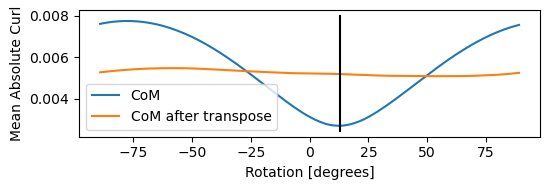

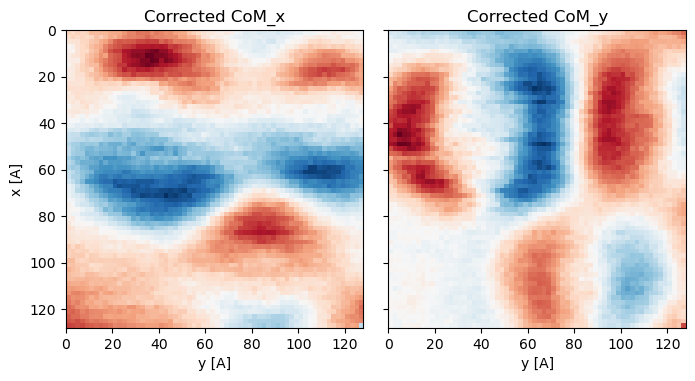

In [10]:
dpc = py4DSTEM.process.phase.DPCReconstruction(
   datacube=dataset, 
   energy = 300e3,
).preprocess()

We first estimate the relative rotation between the real space scanning coordinate system and the diffraction space detector coordinates. This value can be non-zero if the STEM scan coils are rotated to some angle, if the detector is rotated around the optical axis, or if the data has been read incorrectly (transposing x and y or kx and ky for example).

Reconstructing phase: 100%|███████████████████████████████████████████| 64/64 [00:00<00:00, 489.58 iter/s]


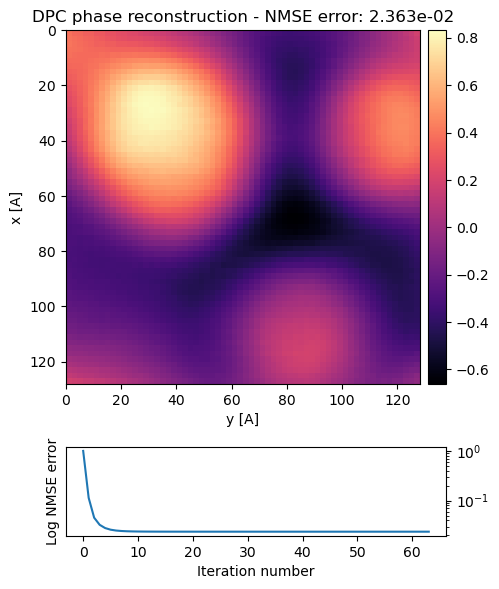

In [11]:
dpc=dpc.reconstruct().visualize()

We see that the particles are very blurry due to the defocused electron probe.  However the signal to noise is much higher, shown by how smooth the outputs are. Phase contrast imaging such as DPC reconstructions are **much** more dose-efficient than bright field or dark field imaging for thin samples.

# Parallax Depth Sectioning

Each pixel in diffraction space can be used to form a virtual image.  On the bright field disk, each of these pixels represents a plane wave of electrons which impacted the sample at a different angle, and because the probe is defocused, a different position on the sample surface. We can computationally align each of these images by using the "parallax operator." This operator corrects the geometric intercepts of each virtual image to be properly focused by aligning the virtual images. The final step is to correct the defocus either by solving the full complex wave (S-matrix reconstruction) or assuming a weak phase object and using contrast transfer function (CTF)-correction.

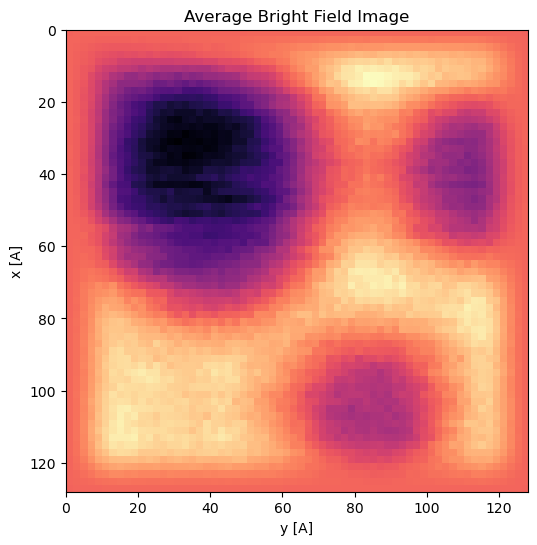

In [12]:
parallax_recon = py4DSTEM.process.phase.ParallaxReconstruction(
    datacube=dataset,
    energy = 300e3,
    #device = "gpu", 
    verbose = True,
    object_padding_px=(16,16),
).preprocess(
    normalize_images=False,
    plot_average_bf=True,
    edge_blend=8,
)

Alignment at bin 2: 100%|████████████████████████████████| 2418/2418 [00:13<00:00, 177.81 image subsets/s]


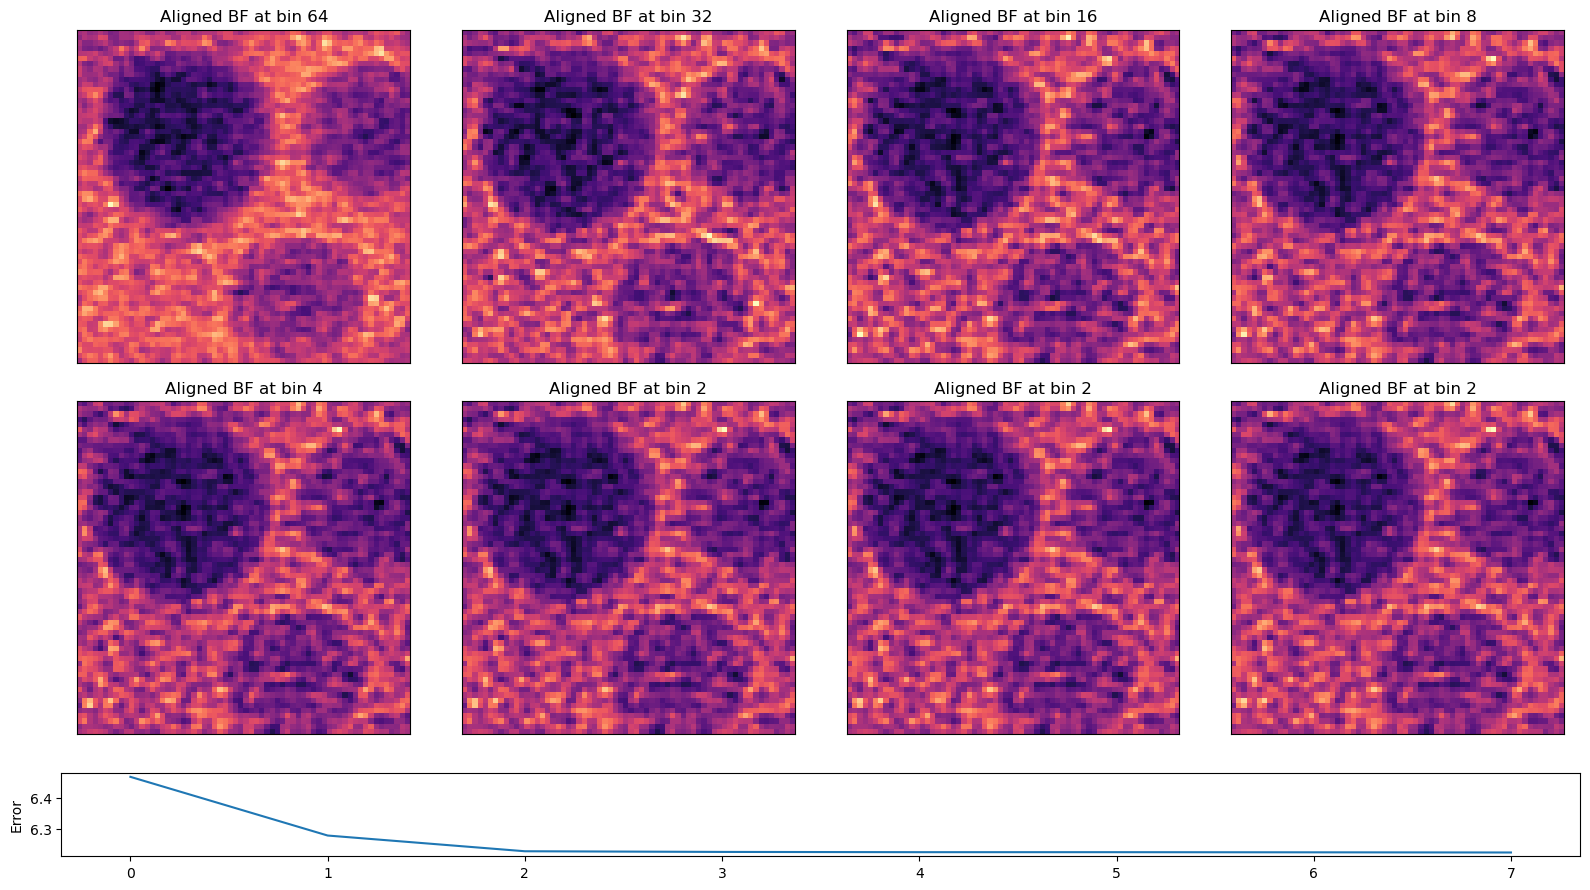

In [13]:
parallax_recon = parallax_recon.reconstruct(
    reset=True,
    min_alignment_bin=2,
    regularizer_matrix_size=(2,2),
    max_iter_at_min_bin = 3,
    regularize_shifts=True,
    running_average=True,
)

Note how much sharper the images are!  The tilt-shift parallax correction has brought the sum of all images into focus.  

We can visualize the cross-correlation shifts for each BF pixel to get a sense of the aberration surface:

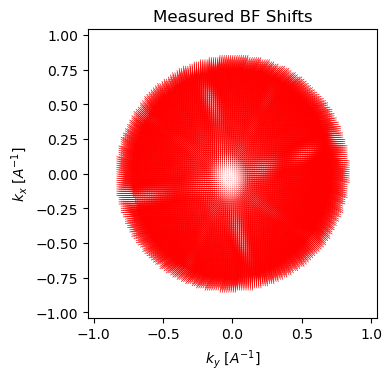

In [14]:
parallax_recon.show_shifts(
    #plot_arrow_freq=2,
)

The sampling of the reconstructed images above is given by the scan step-size. However, the cross-correlation vector shifts have subpixel precision, and thus we can upsample our reconstruction and use kernel-density estimation (KDE) to align the virtual BF images.

/home/gvarnavides/SoftwareHub/py4DSTEM/py4DSTEM/process/phase/iterative_parallax.py:1113: UserWarning: Upsampling factor set to 3.81 (the dark-field upsampling limit).
  warnings.warn(


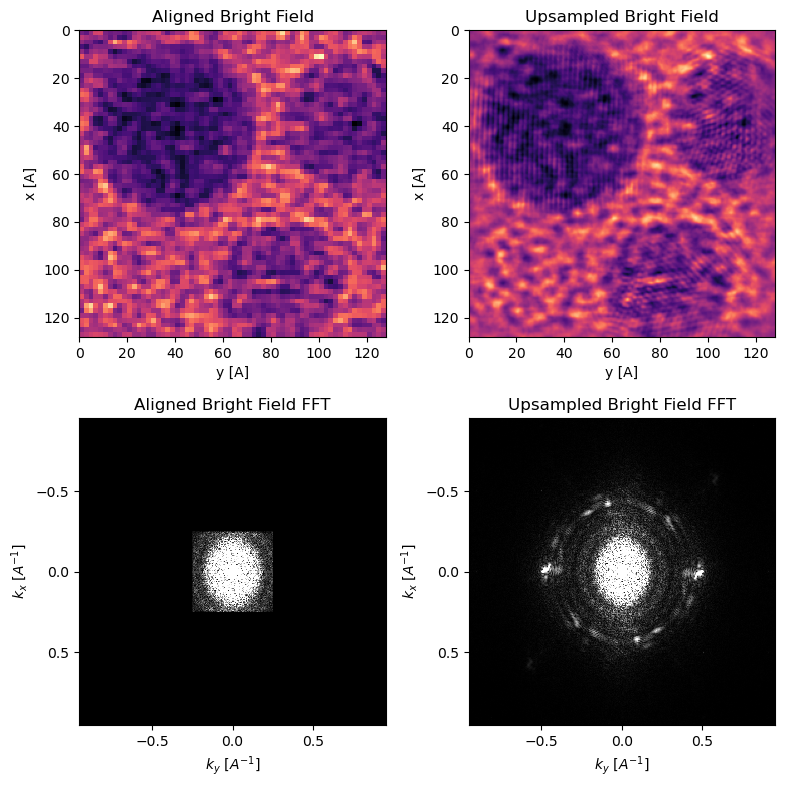

In [15]:
parallax_recon.subpixel_alignment(
    #kde_upsample_factor=2,
    kde_sigma=0.125,
    plot_upsampled_BF_comparison=True,
    plot_upsampled_FFT_comparison=True,
)

Comparing the two FFTs out to the same scattering angle we can see the upsampled image has "unwrapped" the CTF and indicates Bragg peaks corresponding to atomic-spacings in Au, which are clearly visible in the aligned upsampled BF image!

The parallax reconstruction holds a great deal of information on the aberration surface, which can be estimated directly from the cross-correlation shifts and/or the FFT Thon rings. First, we can solve for low-order aberrations such as defocus, and astigmatism using a simple 2x2 affine transform of the measured cross-correlation shifts:

Rotation of Q w.r.t. R = 11.646 deg
Astigmatism (A1x,A1y)  = (103,29) Ang
Aberration C1          =  -1025 Ang
Defocus dF             = 1025 Ang
Transpose              = False


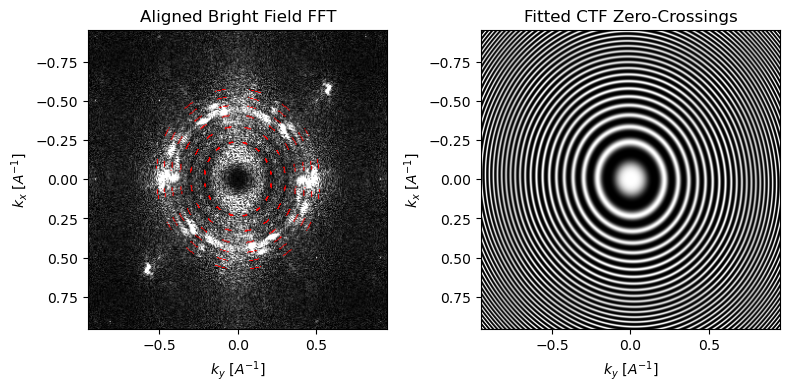

In [16]:
parallax_recon.aberration_fit(
    plot_CTF_comparison=True,
)

More generally, we can fit a least-squares solution to the measured cross-correlation shifts by relating them to the gradient of the aberration surface:

Initial Aberration coefficients
-------------------------------
Rotation of Q w.r.t. R = 11.646 deg
Astigmatism (A1x,A1y)  = (103,29) Ang
Aberration C1          =  -1025 Ang
Defocus dF             = 1025 Ang
Transpose              = False

Refined Aberration coefficients
-------------------------------
aberration    radial   angular   dir.   coefs
name          order    order             Ang 
----------   -------   -------   ----   -----
C1              2        0         -      -1025
stig            2        2         x      103
stig            2        2         y      30
coma            3        1         x      992
coma            3        1         y      -5637
trefoil         3        3         x      -1638
trefoil         3        3         y      -492


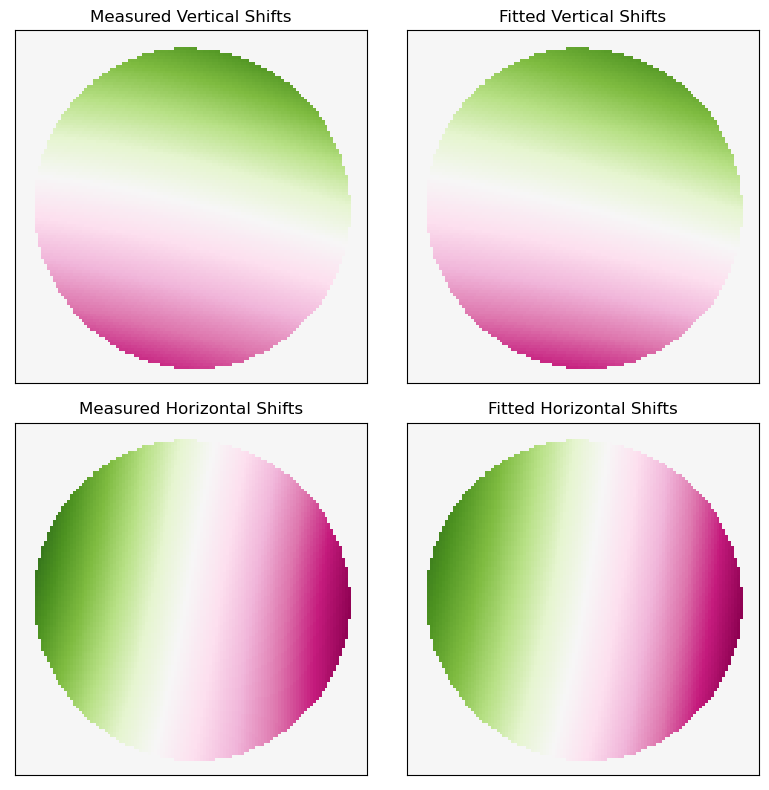

In [17]:
parallax_recon.aberration_fit(
    fit_BF_shifts=True,
    fit_aberrations_max_radial_order=3,
    fit_aberrations_max_angular_order=3,
)

Finally, we can fit the FFT Thon rings for zero-crossings:

Initial Aberration coefficients
-------------------------------
Rotation of Q w.r.t. R = 11.646 deg
Astigmatism (A1x,A1y)  = (103,29) Ang
Aberration C1          =  -1025 Ang
Defocus dF             = 1025 Ang
Transpose              = False

Refined Aberration coefficients
-------------------------------
aberration    radial   angular   dir.   coefs
name          order    order             Ang 
----------   -------   -------   ----   -----
C1              2        0         -      -1003
stig            2        2         x      91
stig            2        2         y      10
coma            3        1         x      0
coma            3        1         y      0
trefoil         3        3         x      0
trefoil         3        3         y      0


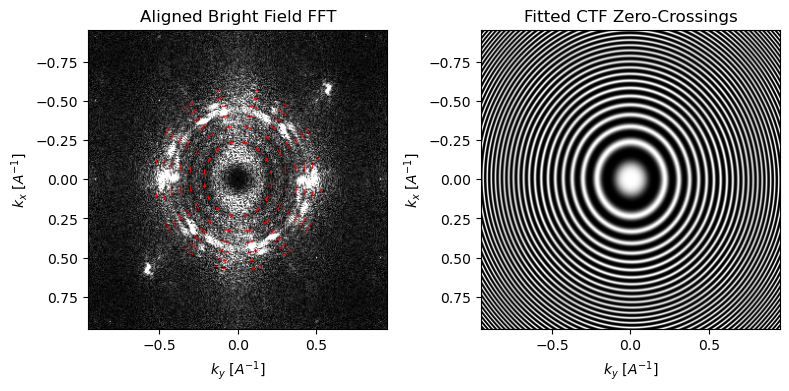

In [18]:
parallax_recon.aberration_fit(
    fit_CTF_FFT=True,
    fit_aberrations_max_radial_order=3,
    fit_aberrations_max_angular_order=3,
)

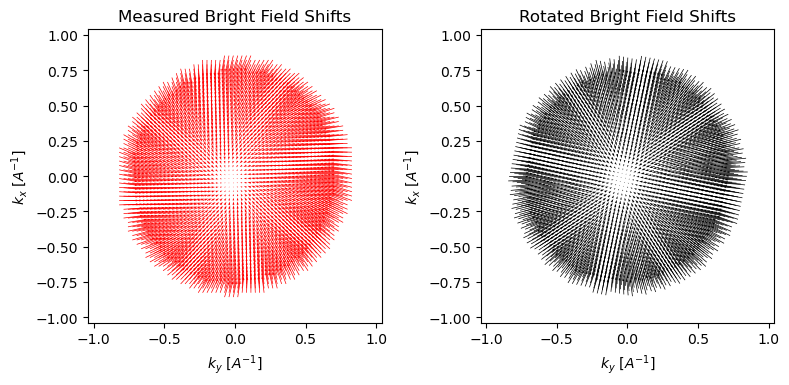

In [21]:
parallax_recon.show_shifts(
    plot_arrow_freq=2,
)

We can use the fitted CTF to correct the subpixel-aligned BF-image:

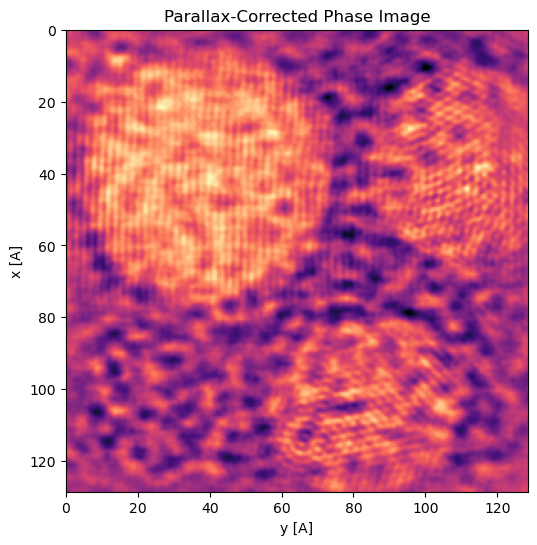

In [19]:
parallax_recon.aberration_correct(
    use_CTF_fit=True,
)

# Ptychography

To reconstruct the complex object wave including both amplitude and phase, while simultaneously solving for the probe aberrations and deconvolving the probe, we will use ptychography. Notes

- We use the initial rotation estimate from the previous parallax measurements.
- We use the initial defocus estimate from the previous parallax measurements.

/home/gvarnavides/SoftwareHub/py4DSTEM/py4DSTEM/process/phase/iterative_base_class.py:648: UserWarning: Best fit rotation forced to 12 degrees.
  warnings.warn(
/home/gvarnavides/SoftwareHub/py4DSTEM/py4DSTEM/process/phase/iterative_base_class.py:662: UserWarning: Transpose of intensities forced to False.
  warnings.warn(


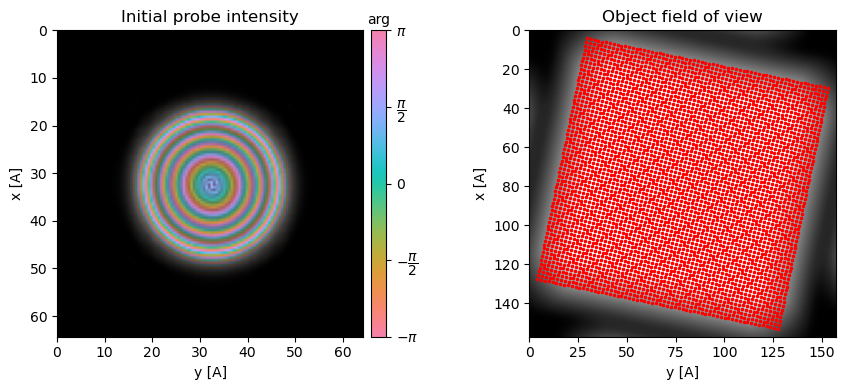

In [23]:
ptycho = py4DSTEM.process.phase.SingleslicePtychographicReconstruction(
    datacube=dataset,
    #device = 'gpu',
    energy = 300e3,
    vacuum_probe_intensity = probe.data,
    object_padding_px=(8,8),
    defocus = -parallax_recon.aberration_C1, # 1025
).preprocess(
    plot_center_of_mass = False, 
    plot_rotation = False, 
    plot_probe_overlaps = True, 
    force_com_rotation = np.rad2deg(parallax_recon.rotation_Q_to_R_rads), # 11.65
    force_com_transpose = parallax_recon.transpose, # False
)

Performing 32 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1 and step _size: 0.5, in batches of max 1024 measurements.


Reconstructing object and probe: 100%|█████████████████████████████████| 32/32 [00:06<00:00,  5.15 iter/s]


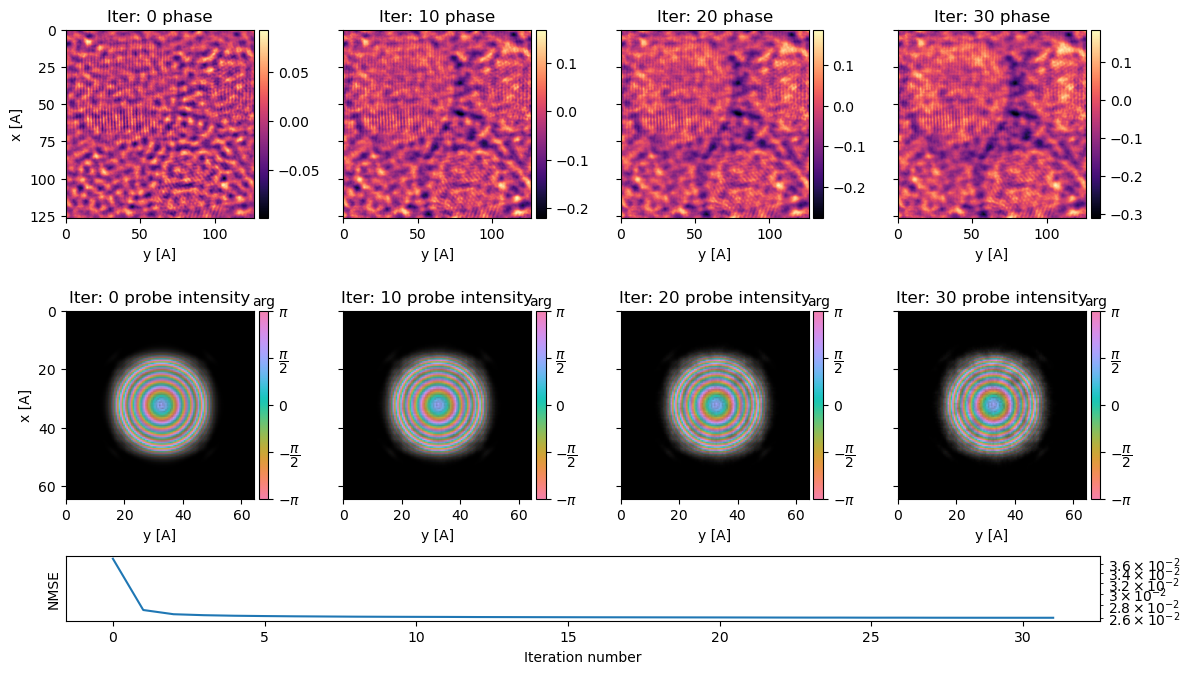

In [24]:
ptycho = ptycho.reconstruct(
    reset = True,
    store_iterations = True,
    max_iter = 32,
    step_size=0.5,
    max_batch_size=ptycho._num_diffraction_patterns//4,
).visualize(
    iterations_grid='auto',
)

To plot only region of the object wave where we have STEM probe measurements, we can use the 'ptycho.object_cropped' property:

(Min,Max) Amplitude: (0.7549,1.007)


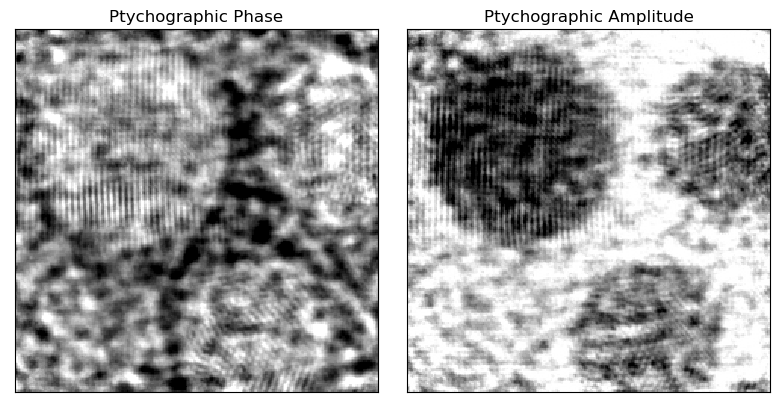

In [25]:
obj = ptycho.object_cropped
print(f'(Min,Max) Amplitude: ({np.abs(obj).min():.4},{np.abs(obj).max():.4})')

py4DSTEM.show(
    [
        np.angle(obj),
        np.abs(obj),
    ],
    title = ['Ptychographic Phase', 'Ptychographic Amplitude'],
    ticks=False,
    axsize=(4,4),
)

We can also visualize the self-consistency errors for each probe position as a measure of uncertainty:

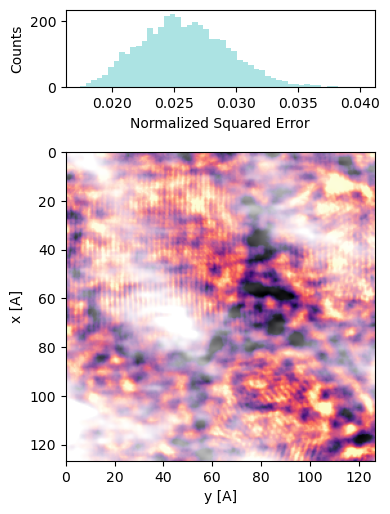

In [29]:
ptycho.show_uncertainty_visualization(
    max_batch_size=ptycho._num_diffraction_patterns//4,
    # plot_contours = False,
    # plot_histogram = True,
    # cmap='magma',
)

## Comparison

We can finally compare the upsampled parallax and ptychographic phase images:

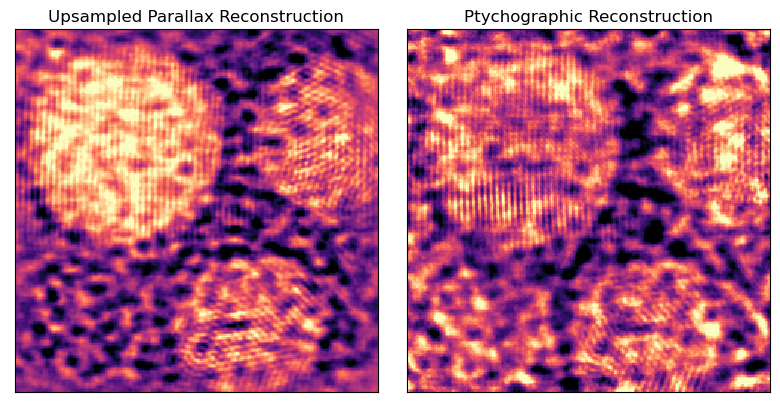

In [30]:
py4DSTEM.show(
    [
        parallax_recon.object_cropped,
        np.angle(ptycho.object_cropped),
    ],
    cmap='magma',
    ticks=False,
    axsize=(4,4),
    title= ["Upsampled Parallax Reconstruction","Ptychographic Reconstruction"]
)

## Saving / Restarting Reconstructions

It is often convenient to save your reconstructions, e.g. to share with collaborators or restart a calculation later.  
This can be achieved using the `py4DSTEM.save` function

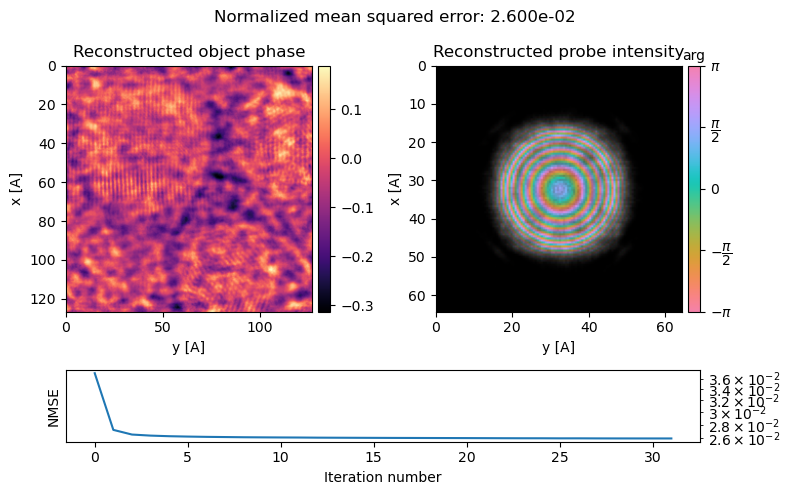

In [31]:
# ptycho = ptycho.set_save_defaults(
#     save_datacube=False,
#     save_exit_waves=False,
#     save_iterations=True,
#     save_iterations_frequency=1,
# )

py4DSTEM.save(file_path+'ptycho_gold_recon.h5',ptycho,mode='o')

new_ptycho = py4DSTEM.read(file_path+'ptycho_gold_recon.h5')
new_ptycho.visualize();

Note that by default the reconstructions don't store the datacube or exit_waves, and write all object/probe iterations with a frequency of 1.
You can change these parameters by changing the commented-out lines above.

Since our file does not include the datacube, we need to re-attach it post-import. Similarly, the reconstructions are stored using device='cpu' to allow compatibility with all devices. If you'd like to reconstruct using the gpu, you need to re-initialize the device parameter.

/home/gvarnavides/SoftwareHub/py4DSTEM/py4DSTEM/process/phase/iterative_base_class.py:648: UserWarning: Best fit rotation forced to 12 degrees.
  warnings.warn(
/home/gvarnavides/SoftwareHub/py4DSTEM/py4DSTEM/process/phase/iterative_base_class.py:662: UserWarning: Transpose of intensities forced to False.
  warnings.warn(
/home/gvarnavides/SoftwareHub/py4DSTEM/py4DSTEM/process/phase/iterative_singleslice_ptychography.py:1527: UserWarning: Continuing reconstruction from previous result. Use reset=True for a fresh start.
  warnings.warn(


Performing 2 iterations using a complex object type, with the gradient-descent algorithm, with normalization_min: 1.


Reconstructing object and probe: 100%|███████████████████████████████████| 2/2 [00:00<00:00,  4.86 iter/s]


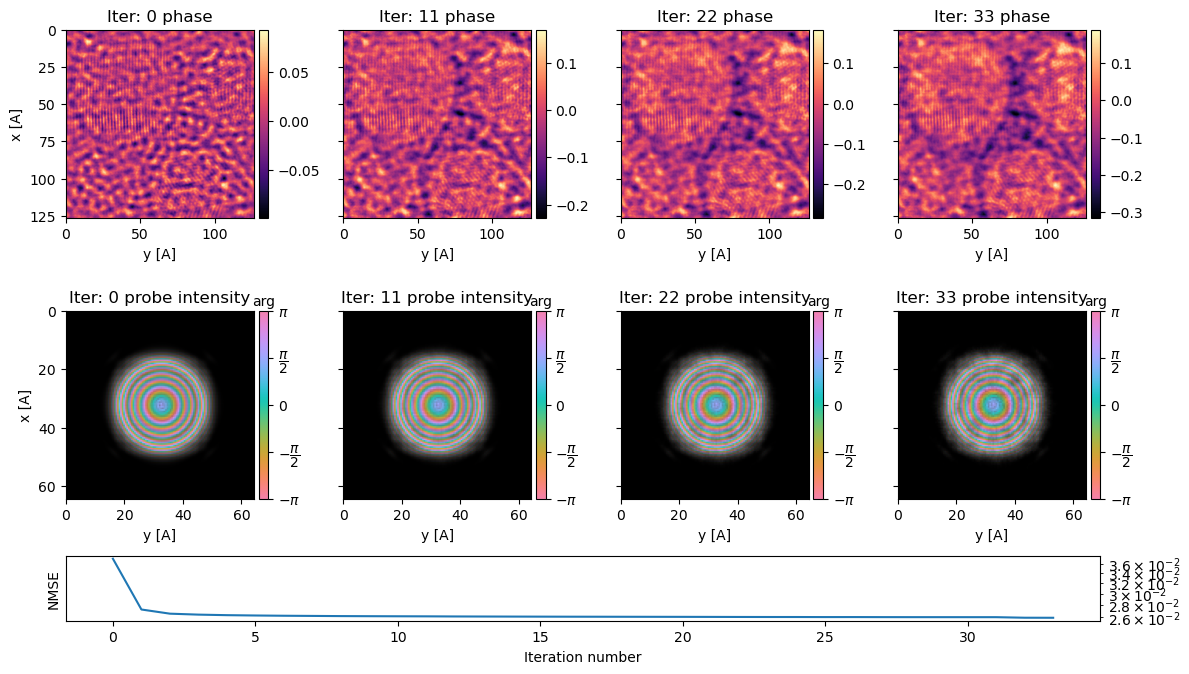

In [32]:
new_ptycho = new_ptycho.attach_datacube(
    dataset,
).reinitialize_parameters(
    #device='gpu',
).preprocess(
    plot_center_of_mass = False, 
    plot_rotation = False, 
    plot_probe_overlaps = False, 
    force_com_rotation = np.rad2deg(parallax_recon.rotation_Q_to_R_rads), # 11.65
    force_com_transpose = parallax_recon.transpose, # False
).reconstruct(
    store_iterations = True,
    max_iter = 2,
    step_size=0.5,
).visualize(
    iterations_grid='auto',
)